# Redes Neuronales NLP

In [49]:
import pandas as pd
import sklearn as sklearn

In [50]:
import os

df=pd.read_excel(
     os.path.join("data", "reclamos_20201221_con_clas.xlsx"),
     engine='openpyxl',
)

In [51]:
df.columns

Index(['CASO_ID', 'MERCADO_ANALISTA', 'DESCRIPCION_CIUDADANO',
       'PETICION_CIUDADANO'],
      dtype='object')

In [52]:
df['MERCADO_ANALISTA']=df['MERCADO_ANALISTA'].astype('category')

In [53]:
df=df[['MERCADO_ANALISTA','PETICION_CIUDADANO','DESCRIPCION_CIUDADANO']].dropna()

In [54]:
df['DESCRIPCION_CIUDADANO']=df['DESCRIPCION_CIUDADANO'].map(str).str.lower()
df['PETICION_CIUDADANO']=df['PETICION_CIUDADANO'].map(str).str.lower() 

In [55]:
df['data'] = df['DESCRIPCION_CIUDADANO'] + df['PETICION_CIUDADANO']

In [56]:
import string, re

def remove_punct(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split()).lower()

df['data']=df['data'].apply(remove_punct)

In [57]:
labels=(df['MERCADO_ANALISTA']=='Reclamo Valores').astype(int)

In [75]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['data'].values)

input_array = tokenizer.texts_to_sequences(df['data'].values)

vocab_size = len(tokenizer.word_index) + 1  

In [76]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

input_array = pad_sequences(input_array, padding='post', maxlen=maxlen)

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_array, labels, test_size=0.2)

# Red Neuronal Recurrente

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, SpatialDropout1D,GlobalMaxPool1D

embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1262600   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 1,263,621
Trainable params: 1,263,621
Non-trainable params: 0
_________________________________________________________________


El modelo recurrente tiende a decrecer la performance. Una alternativa es utilizar embeddings pre-entranados

https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding

In [163]:
#from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout


#embedding_dim = 100

#model = Sequential()
#model.add(Embedding(input_dim=vocab_size, 
#                           output_dim=embedding_dim, 
#                           input_length=maxlen))
#model.add(LSTM(256,return_sequences=True, activation='relu'))
#model.add(LSTM(128, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
#model.summary()

In [164]:
batch_size = 16
history=model.fit(X_train,y_train,epochs=10,batch_size=batch_size,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
50/50 [==============================] - 1s 11ms/step - loss: 0.6734 - accuracy: 0.6183 - val_loss: 0.6533 - val_accuracy: 0.6500
Epoch 2/10
50/50 [==============================] - 1s 10ms/step - loss: 0.6262 - accuracy: 0.6658 - val_loss: 0.6271 - val_accuracy: 0.6500
Epoch 3/10
50/50 [==============================] - 1s 11ms/step - loss: 0.5833 - accuracy: 0.6658 - val_loss: 0.5815 - val_accuracy: 0.6500
Epoch 4/10
50/50 [==============================] - 1s 10ms/step - loss: 0.4895 - accuracy: 0.7409 - val_loss: 0.4797 - val_accuracy: 0.7750
Epoch 5/10
50/50 [==============================] - 1s 10ms/step - loss: 0.3422 - accuracy: 0.8936 - val_loss: 0.3577 - val_accuracy: 0.8750
Epoch 6/10
50/50 [==============================] - 1s 11ms/step - loss: 0.2018 - accuracy: 0.9712 - val_loss: 0.2697 - val_accuracy: 0.8900
Epoch 7/10
50/50 [==============================] - 1s 10ms/step - loss: 0.1155 - accuracy: 0.9887 - val_loss: 0.2266 - val_accuracy: 0.9100
Epoch 8/10
50

In [128]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validacion')
    plt.title('Exactitud')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validacion')
    plt.title('Objetivo')
    plt.legend()

Exactitud Entrenamiento: 1.0000
Exactitud Testing:  0.9350


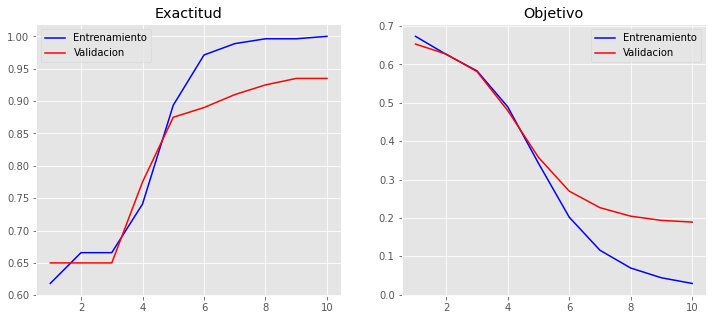

In [165]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

In [166]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, np.int32(y_pred>0.5)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       130
           1       0.95      0.86      0.90        70

    accuracy                           0.94       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.94      0.94      0.93       200



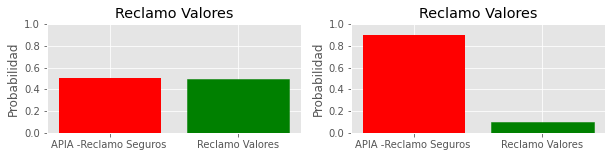

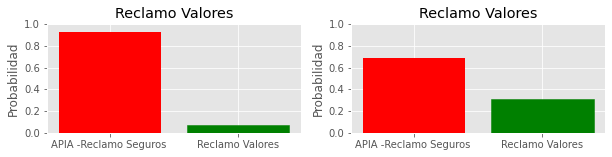

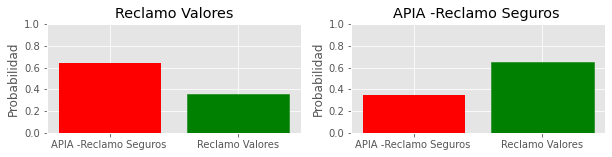

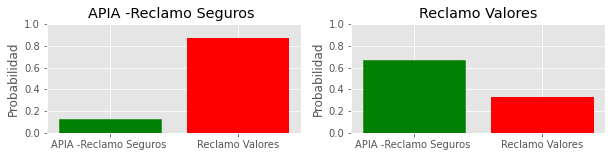

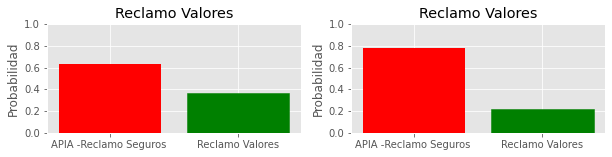

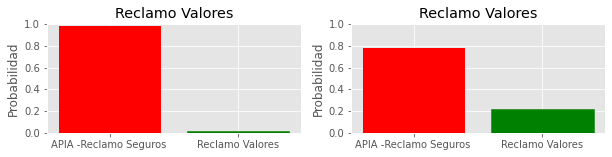

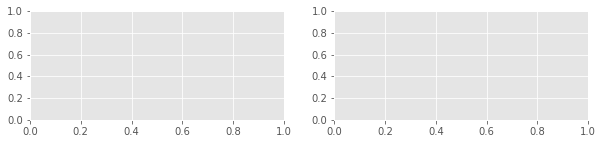

In [167]:
class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(1,n_error+1,2):
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    for j in range(2):
        if(i+j<n_error):
            bar=ax[j].bar(str_labels, err_pred[i+j], color='red')
            bar[int(true_label.iloc[i])].set_color('green')
            ax[j].set_title(str_labels[int(true_label.iloc[i+j])])
            ax[j].set_ylim([0, 1])
            ax[j].set_ylabel('Probabilidad')
plt.show()

# Red Neuronal Recurrente Probabilista

In [215]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

divergence_fn = lambda q , p , _ : tfd.kl_divergence(q,p)/X_train.shape[0]

def prior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    prior_model=Sequential([
        tfpl.DistributionLambda(
        lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),scale_diag=tf.ones(n)))
    ])
    return prior_model


def posterior(kernel_size,bias_size,dtype=None):
    n=kernel_size+bias_size
    posterior_model=Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

model = Sequential([
    Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen),
    GlobalMaxPool1D(),
    tfpl.DenseVariational(units=10,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0],
                          activation='relu'),
    tfpl.DenseVariational(units=tfpl.IndependentBernoulli.params_size(1),
                          activation=None,
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/X_train.shape[0]),
    tfpl.IndependentBernoulli(1)
])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          1262600   
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 100)               0         
_________________________________________________________________
dense_variational_12 (DenseV (None, 10)                511565    
_________________________________________________________________
dense_variational_13 (DenseV (None, 1)                 77        
_________________________________________________________________
independent_bernoulli_5 (Ind ((None, 1), (None, 1))    0         
Total params: 1,774,242
Trainable params: 1,774,242
Non-trainable params: 0
_________________________________________________________________


In [216]:
from tensorflow.keras.optimizers import RMSprop

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(optimizer='adam',
              loss=nll,
              metrics=['accuracy'])

In [217]:
batch_size =16
history=model.fit(X_train,y_train,epochs=100,batch_size=batch_size,validation_data=(X_test, y_test),verbose=0)

Exactitud Entrenamiento: 0.7760
Exactitud Testing:  0.6850


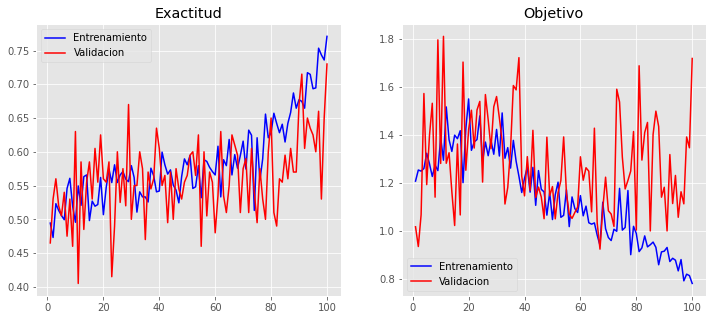

In [218]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Exactitud Entrenamiento: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Exactitud Testing:  {:.4f}".format(accuracy))
plot_history(history)

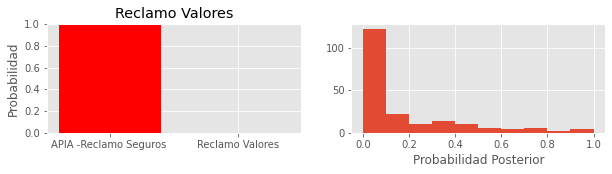

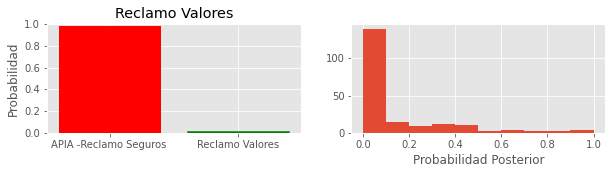

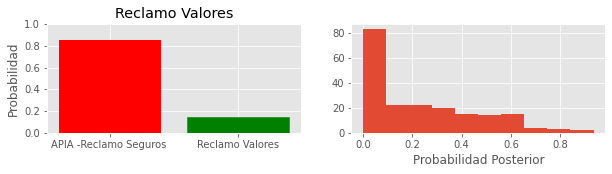

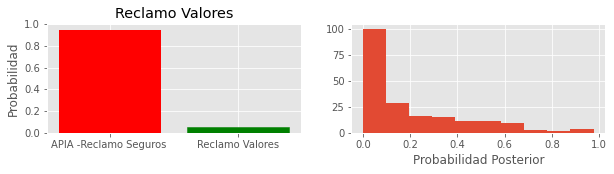

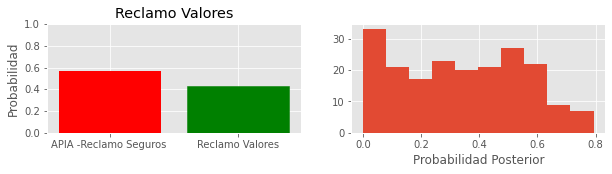

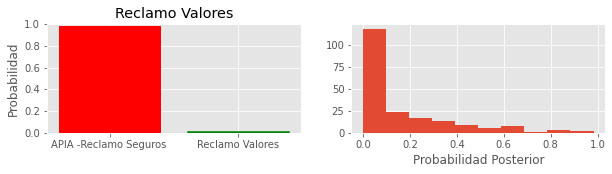

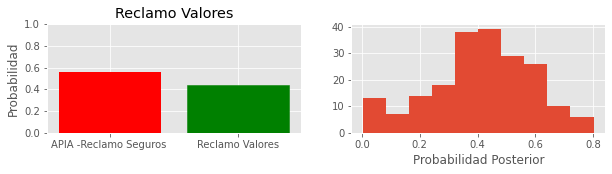

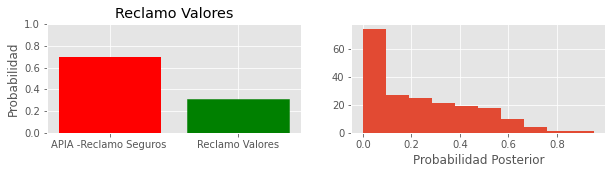

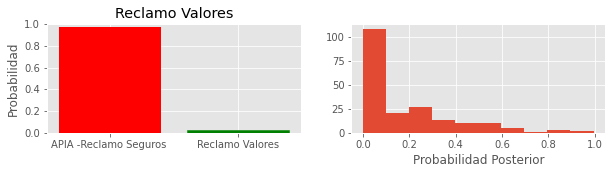

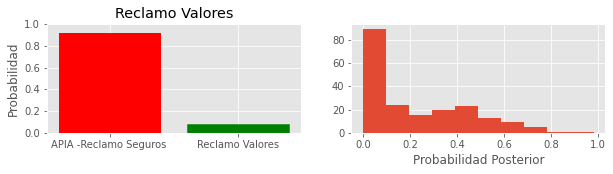

In [267]:
y_pred=model(X_test).mean().numpy()
class_error=np.int32(y_pred>0.5).flatten()!=y_test
err_pred=y_pred[class_error]
err_pred=np.hstack([1-err_pred,err_pred])
true_label=y_test[class_error]
X_error=X_test[class_error]
n_error=len(true_label)
str_labels=df['MERCADO_ANALISTA'].unique()

for i in range(10):
    predicted_probabilities=[]
    for _ in range(200):
        predicted_probabilities.append(model(X_error[i][np.newaxis, ...]).mean().numpy()[0])
    predicted_probabilities=np.stack(predicted_probabilities).flatten()
    fig, ax = plt.subplots(1,2,figsize=(10, 2))
    bar=ax[0].bar(str_labels, err_pred[i], color='red')
    bar[int(true_label.iloc[i])].set_color('green')
    ax[0].set_title(str_labels[int(true_label.iloc[i+j])])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('Probabilidad')
    ax[1].hist(predicted_probabilities)
    ax[1].set_xlabel('Probabilidad Posterior')
plt.show()

In [268]:
y_pred

array([[4.28549536e-02],
       [4.60676197e-03],
       [2.26047193e-03],
       [3.37145291e-04],
       [4.76035327e-02],
       [1.98990360e-01],
       [8.26228224e-03],
       [1.78894214e-03],
       [2.03329753e-02],
       [6.71541179e-03],
       [2.77051376e-03],
       [1.62291937e-02],
       [1.95551990e-03],
       [2.42351234e-01],
       [1.47942174e-02],
       [1.43845439e-01],
       [2.45934930e-02],
       [5.58647811e-02],
       [1.65166822e-03],
       [4.28806335e-01],
       [2.57300417e-04],
       [4.32756357e-03],
       [3.93080059e-03],
       [1.66090354e-02],
       [4.28430467e-05],
       [1.39777035e-01],
       [3.92905883e-02],
       [1.49694202e-03],
       [5.86256711e-03],
       [8.61798879e-04],
       [7.20706477e-04],
       [3.81796271e-01],
       [4.37948436e-01],
       [1.02273030e-02],
       [9.52512084e-04],
       [3.07249308e-01],
       [2.48988383e-02],
       [1.48965837e-05],
       [4.93547879e-03],
       [3.29524785e-01],
